# Описание проекта

Интернет-магазине «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

В учебных целях анализируем данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.

# Описание данных

Name — название игры  
Platform — платформа  
Year_of_Release — год выпуска  
Genre — жанр игры  
NA_sales — продажи в Северной Америке (миллионы проданных копий)  
EU_sales — продажи в Европе (миллионы проданных копий)  
JP_sales — продажи в Японии (миллионы проданных копий)  
Other_sales — продажи в других странах (миллионы проданных копий)  
Critic_Score — оценка критиков (максимум 100)  
User_Score — оценка пользователей (максимум 10)  
Rating — рейтинг от организации ESRB  
(англ. Entertainment Software Rating Board).  
Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats as st
import seaborn as sns

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


# Изучение таблицы

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.duplicated().sum()

0

Датасет состоит из 11 столбцов и 16715 строк. Дубликатов не обнаружено.
Видим пропуски в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating.  
Для столбца User_Score поменяем формат на числовой. 

# Подготовка данных

Заменим названия столбцов (приведем к нижнему регистру);    
Преобразуем данные в нужные типы;  
Обработаем пропуски при необходимости;    
Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [6]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Приводим названия столбцов к нижнему регистру.

In [7]:
#games['user_score']= games['user_score'].astype('float64')

Поменять тип данных пока не получилось из-за tbd(to be determined- быть определённым) значений. Пишется абревиатура тогда, когда игра имеет недостаточное количество отзывов, тут можно предположить, что не все пользователи игр могут оставлять отзывы на англоязычных ресурсах, а кто-то из них просто пока не оставил, поэтому меняем это значение на NAN. 

In [8]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score']= games['user_score'].astype('float64')

Меняем тип user_score на числовой дробный, подобно другим столбцам с рейтингами, так как
для дальнейших исследований тип object помешает анализу. 

In [9]:
display(games.loc[games['rating'] =='tbd', 'rating'].count())

0

 Проверяем наличие tbd в столбце rating


# Пропуски

In [10]:
games.loc[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Проверяем пропуски в столбце Names(так совпало, что в этих строках так же пропуски в столбце Genre, поэтому заодно избавляемся от них тоже), видим что в строках пропущены поти все данные и они будут неинформативны  в дальнейшем, поэтому- удаляем и проверяем, что пропусков теперь 0:

In [11]:
games = games.dropna(subset=['name'])
games['name'].isnull().sum()

0

В столбце year_of_release посмотрим количество пропусков

In [12]:
games.loc[games['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [13]:
games['year_of_release'].isna().sum()

269

In [14]:
games['year_of_release'] = games['year_of_release'].dropna().astype('Int64')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null Int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


In [15]:
games.duplicated().sum()

0

In [16]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Делаем отдельный столбец для суммарных продаж

In [17]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Вывод по пропускам в Critic_Score, User_Score, Rating:  
Пока мы не будем их заменять, потому что реальные оценки могут не совпадать со средними значениями. Возможно рейтинги и оценки существовали не с самого начала выпуска игр, поэтому их может не быть.

In [18]:
games['rating'].isna().sum()

6764

In [19]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

In [20]:
games['rating']=games['rating'].fillna(0).replace(0, 'Без рейтинга')
games['rating'].isna().sum()

0

In [21]:
games['rating'].value_counts()

Без рейтинга    6764
E               3990
T               2961
M               1563
E10+            1420
EC                 8
RP                 3
K-A                3
AO                 1
Name: rating, dtype: int64

#  Исследовательский анализ данных 

##  Посмотрим,  сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [22]:
games_by_year = games.query('name != "not_stated"').pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
display(games_by_year)

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


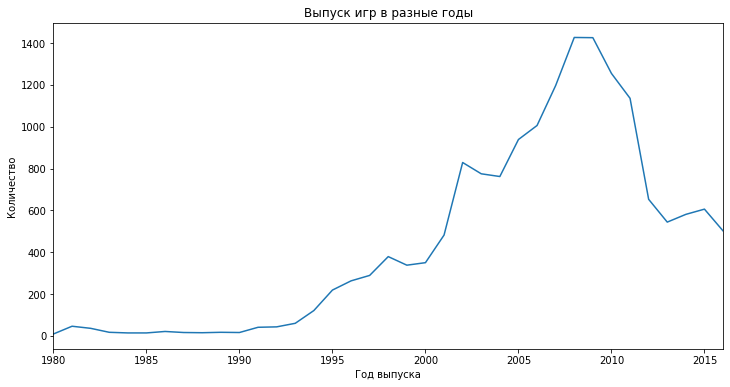

In [23]:
games_by_year.plot(figsize=(12, 6), legend=False, title='Выпуск игр в разные годы').set(xlabel='Год выпуска', ylabel='Количество')
plt.show()

Из графика видно, что с 1980 года по 1993 игры выпускались мало и продаж не было, соответственно эти годы можно не учитывать. Затем идет  рост, его пик приходится на 2008-2009 гг., уровень продаж в 2016 году примерно как и в 2001.

## Посмотрим, как менялись продажи по платформам и выберем платформы с наибольшими суммарными продажами и постройте распределение по годам. 

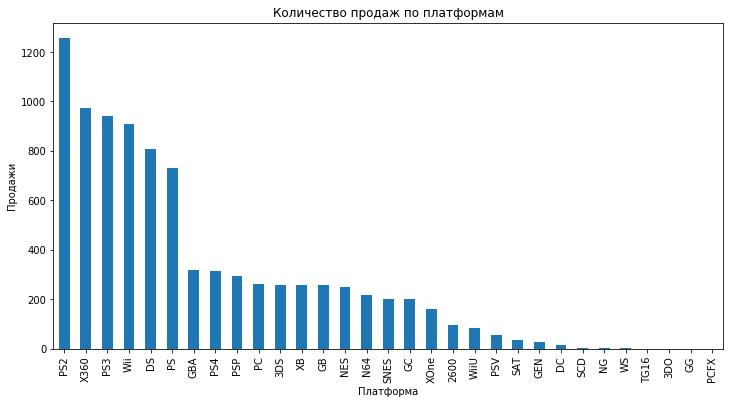

In [24]:
sales_by_platform = games.pivot_table(index='platform', values = 'total_sales', aggfunc='sum').sort_values('total_sales', ascending=False)
def make_bar_plot(games):
    games.plot(kind='bar', y = 'total_sales', legend=False, title='Количество продаж по платформам', figsize=(12, 6)).set(xlabel='Платформа',ylabel='Продажи')
    plt.show()
make_bar_plot(sales_by_platform)

[Text(87.0, 0.5, 'Платформа'),
 Text(0.5, 51.0, 'Год выпуска'),
 Text(0.5, 1, 'Срок сущeствования платформ')]

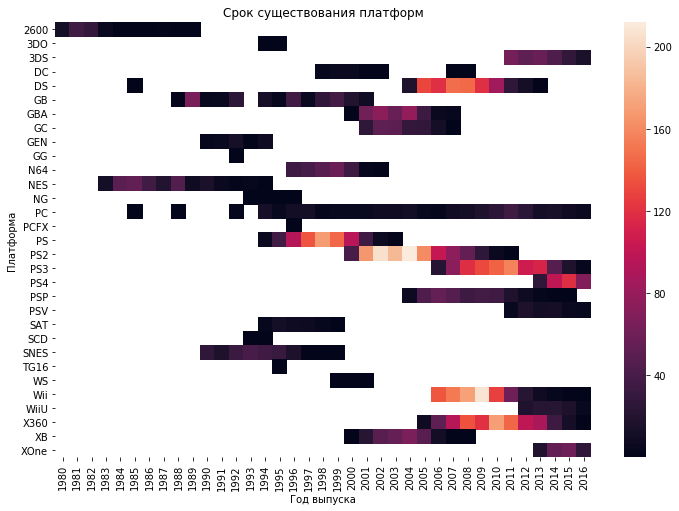

In [25]:
games_plat=games.pivot_table(index="platform",columns = 'year_of_release',values='total_sales',aggfunc = ('sum'))
plt.figure(figsize=(12,8))
sns.heatmap(games_plat).set(title = 'Срок сущeствования платформ', xlabel = 'Год выпуска',ylabel='Платформа')

Если посмотреть срок жизни всех платформ с 1980 года, то можно увидеть, как новые платформы сменяют старые, например, у ps,ps2,ps3,ps4 один производитель - Sony.

In [26]:
top_5_platforms = sales_by_platform.head()
top_5_platforms

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12


[Text(69.0, 0.5, 'Платформа'),
 Text(0.5, 24.0, 'Год выпуска'),
 Text(0.5, 1, 'Срок сущeствования 5 популярных платформ')]

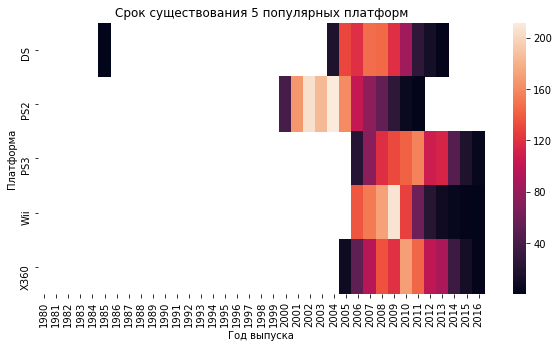

In [27]:
games_plat=games.pivot_table(index="platform",columns='year_of_release',values='total_sales',aggfunc=('sum'))
list_platform=['PS2','PS3','Wii','X360','DS'] 
top_platform=games_plat.query('platform in @list_platform')
plt.figure(figsize=(10,5))
sns.heatmap(top_platform).set(title = 'Срок сущeствования 5 популярных платформ', xlabel='Год выпуска',ylabel='Платформа')

Срок существовоания платформ согласно графику в среднем 10-11 лет. Примерно через 5 лет(в середине) происходит пик продаж. На примере PS2 видно, что на пике производитель запустил PS3, поэтому пользование PS2 теряет популярность. Исключение платформа Wii- у нее хорошие продажи были в самом начале и с 4 года службы происходит спад.

## Прогноз на 2017 год исходя из данных за предыдущие 2 года

[Text(0, 0.5, 'Продажи'), Text(0.5, 0, 'Платформа')]

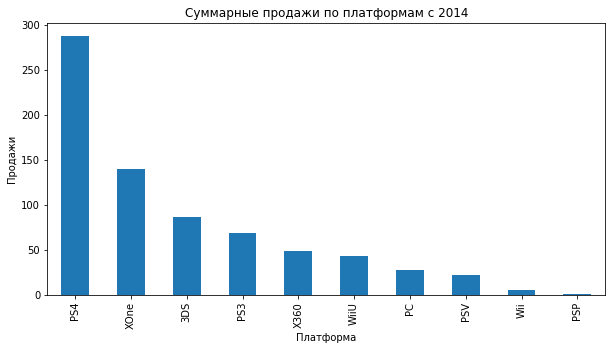

In [28]:
actual_platform=games.query('year_of_release >= 2014')
actual_platform.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(figsize=(10,5),kind="bar",title='Суммарные продажи по платформам с 2014').set(xlabel='Платформа',ylabel='Продажи')

[Text(69.0, 0.5, 'Платформа'),
 Text(0.5, 24.0, 'Год выпуска'),
 Text(0.5, 1, 'Срок сущeствования 5 популярных платформ c 2014 года')]

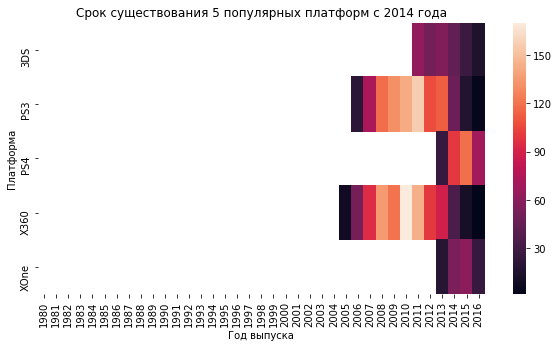

In [29]:
list_platform=['3DS','PS3','PS4','X360','XOne'] # Список активных платформ 
top_platform= games_plat.query('platform in @list_platform')
plt.figure(figsize=(10,5))
sns.heatmap(top_platform).set(title = 'Срок сущeствования 5 популярных платформ c 2014 года', xlabel='Год выпуска',ylabel='Платформа')

Выше представлен график активных платформ за актуальный период. По нему видно, что продажи  PS4 только-только начинают падать. Это значит, что примено через год будет выходить новая платформа.На 2016 год самые перспективные ировые платформы - PS4 и XOne, в 2017 году они могут выйти на пик продаж.

## График «ящик с усами» по глобальным продажам игр в разбивке по платформам

In [30]:
actual_platform = games.query('platform in @list_platform and year_of_release >= 2014')
#Дата сет с активными платформами и актуальным периодом
actual_platform.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Без рейтинга,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Без рейтинга,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,Без рейтинга,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
96,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,Без рейтинга,7.55
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,Без рейтинга,7.39
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17


[Text(0, 0.5, 'Продажи'),
 Text(0.5, 0, 'Платформы'),
 Text(0.5, 1.0, 'График «ящик с усами» по глобальным продажам игр в разбивке по платформам')]

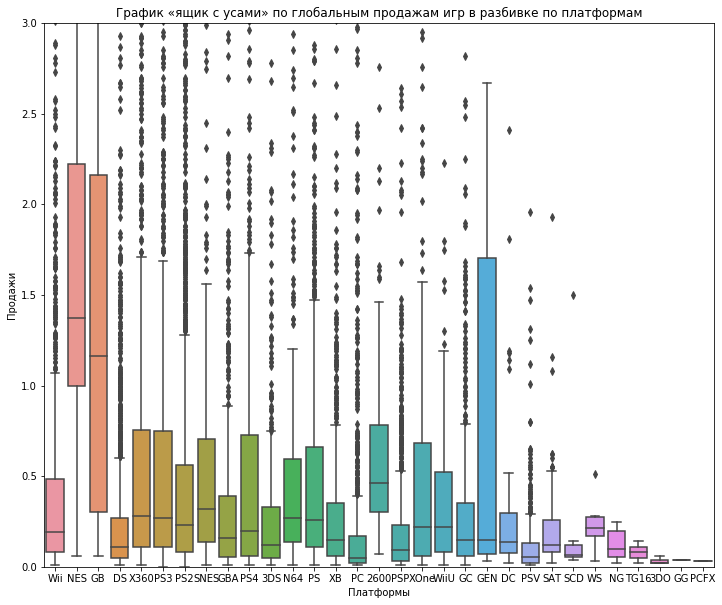

In [31]:
plt.figure(figsize=(12,10))
plt.ylim(0,3)
sns.boxplot(x='platform',y='total_sales', data=games).set(title = 'График «ящик с усами» по глобальным продажам игр в разбивке по платформам', xlabel='Платформы',ylabel='Продажи')

Межквартальный размах очень схож у платфором X360, PS3, PS4, PS, XOne. Все распределения платформ скошены вправо. Также у всех ящиков медина лежит левее среднего значения. У компаний, у которых пользовательский интерес ниже имеют медиану около 0.1-0.2.

[Text(0, 0.5, 'Продажи'),
 Text(0.5, 0, 'Платформы'),
 Text(0.5, 1.0, 'График «ящик с усами» по глобальным продажам 5 популярных платформ')]

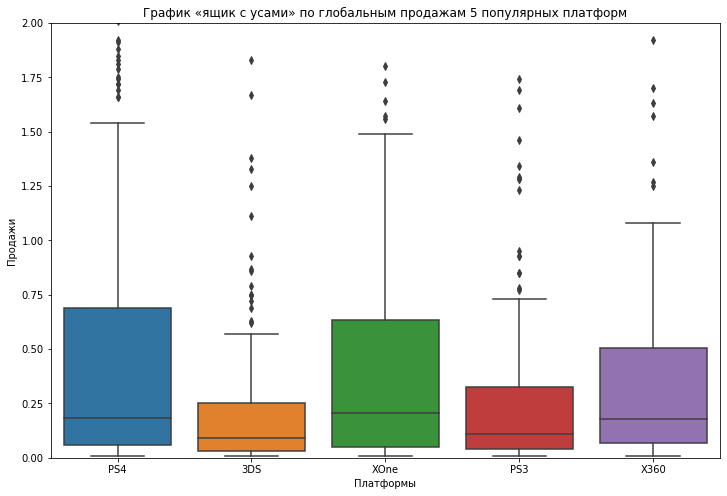

In [32]:
plt.figure(figsize=(12,8))
plt.ylim(0,2)
sns.boxplot(x='platform',y='total_sales',data = actual_platform).set(title = 'График «ящик с усами» по глобальным продажам 5 популярных платформ', xlabel='Платформы',ylabel='Продажи')

Кроме платформы 3DS, все ящики с усами  похожи.  У 3DS третий квартиль меньшем у остальных. Медиана схожа, боксплот платформ скошен вправо.

In [33]:
mean_sales = actual_platform.groupby('platform')['total_sales'].mean().sort_values(ascending=False)
median_sales= actual_platform.groupby('platform')['total_sales'].median().sort_values(ascending=False)

display(mean_sales)
display(median_sales)

platform
PS4     0.766356
XOne    0.615614
X360    0.434414
3DS     0.408868
PS3     0.311324
Name: total_sales, dtype: float64

platform
XOne    0.205
PS4     0.185
X360    0.180
PS3     0.110
3DS     0.090
Name: total_sales, dtype: float64

Проверка показывает, то медианные значения 5 популярных платформ ниже средних значений.

## Влияние на продажи внутри одной популярной платформы отзывы пользователей и критиков. Диаграмма рассеяния и корреляцию между отзывами и продажами. 

[Text(0, 0.5, 'Продажи'), Text(0.5, 0, 'Отзывы критиков')]

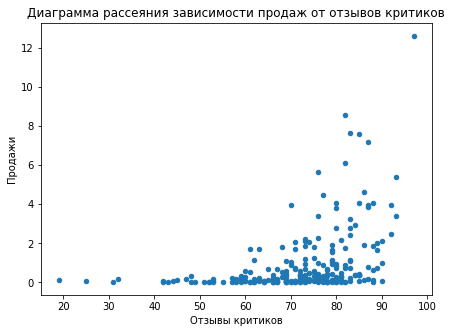

In [34]:
actual_platform.query('platform=="PS4"').sort_values(by='critic_score').plot(kind='scatter',x='critic_score',y='total_sales',figsize=(7,5), title = 'Диаграмма рассеяния зависимости продаж от отзывов критиков').set(xlabel='Отзывы критиков',ylabel='Продажи')

[Text(0, 0.5, 'Продажи'), Text(0.5, 0, 'Отзывы пользователей')]

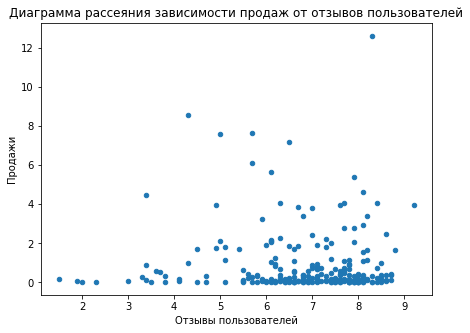

In [35]:
actual_platform.query('platform=="PS4"').sort_values(by='user_score').plot(kind='scatter', x='user_score',y='total_sales',figsize=(7,5), title = 'Диаграмма рассеяния зависимости продаж от отзывов пользователей').set(xlabel='Отзывы пользователей',ylabel='Продажи')


Зависимости от отзывов в продажах согласно графикам не наблюдается. Посмотрим на корреляцию:

In [36]:
ps4_actual = actual_platform.query('platform=="PS4"')
display(ps4_actual['total_sales'].corr(ps4_actual['user_score']))
display(ps4_actual['total_sales'].corr(ps4_actual['critic_score']))

-0.040131589472697356

0.40266141068104083

Отзывы критиков больше влияют на продажи, чем отзывы пользователей. Корреляция в обоих случаях положительная, хотя у пользователей очень слабая. Тут еще имеет значение популярность, пользовательские рецензии обычно влияют на менеее раскрученные или новые игры.

## Общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

[Text(0, 0.5, 'Продажи'), Text(0.5, 0, 'Жанр')]

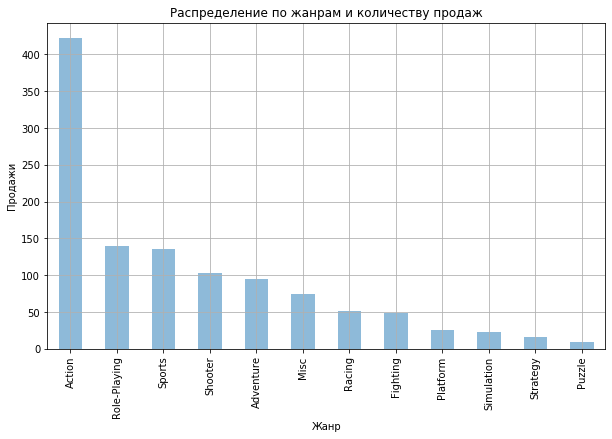

In [37]:
count_genre=actual_platform.groupby('genre')['total_sales'].count()
count_genre=actual_platform.groupby('genre')['total_sales'].count().sort_values(ascending=False)
count_genre.plot(y='genre',grid=True,figsize=(10,6),kind='bar',alpha=0.5,title='Распределение по жанрам и количеству продаж').set(xlabel='Жанр',ylabel='Продажи')

Самым прибыльным жанром по миру является Action. Менее всех популярен Puzzle.

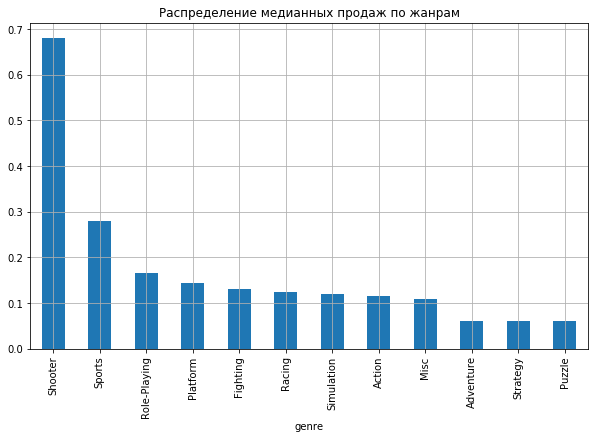

In [38]:
median_sale_genre=actual_platform.groupby('genre')['total_sales'].median().sort_values(ascending=False)
median_sale_genre.plot(y='genre',grid=True,figsize=(10,6),kind='bar',title='Распределение медианных продаж по жанрам')


Согласно медианным значениям самые прибыльные жанры это Shooter, Sports, Role-Playing. 

# Портрет пользователя каждого региона

In [39]:
def profiler(index, values): 
        display(actual_platform.pivot_table(index = index, values = values, aggfunc = 'sum')
                .sort_values(values , ascending = False)
                             .plot(kind='bar'))


5 самых популярных платформ за актуальный период:

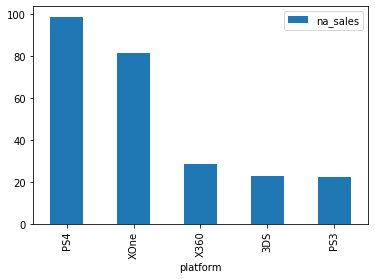

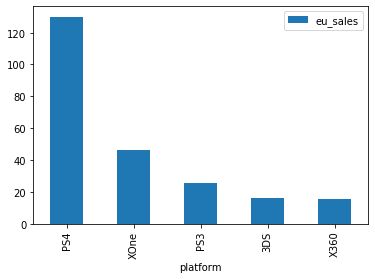

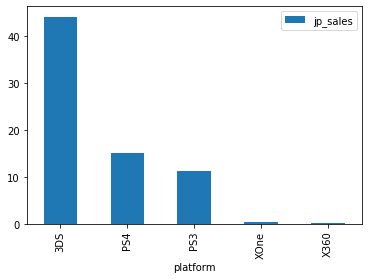

In [40]:
profiler('platform', 'na_sales')
profiler('platform', 'eu_sales')
profiler('platform', 'jp_sales')

Самая популярная платформа в США- X360, затем PS3 (c небольшой разницей), и набирает обороты PS4.  
У Европейских пользователей лидирует PS3, затем идет Х360 и далее PS4.  
Японские пользователи предпочитают платформу 3DS остальным, далее идет PS3, далее с большим отрывом PS4.  

5 самых популярных жанров:

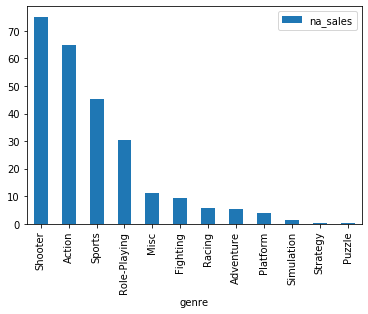

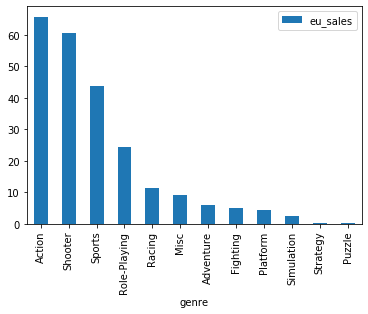

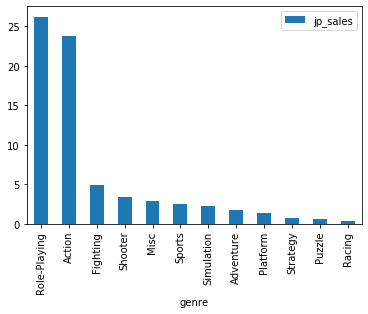

In [41]:
profiler('genre', 'na_sales')
profiler('genre', 'eu_sales')
profiler('genre', 'jp_sales')

В США самый популярный жанр  Shooter, с небольшим отрывом Action и далее идет Sports.
У Европейских пользователей лидирует Action, потом Shooter, и далее Sports.
Японские пользователи опять отличаются своим выбором, наиболее частый жанр Role-Playing, далее Action и затем Fighting.

Влияние рейтинга ESRB на продажи в отдельном регионе:

Entertainment Software Rating Board (ESRB) — негосударственная саморегулирующаяся организация, которая присваивает рейтинги компьютерным и видеоиграм, а также другому развлекательному программному обеспечению в США. Получение рейтинга добровольно, однако необходимо для успешных продаж на территории США.

Типирование рейтинга в датасете:

E -  everyone  
EC early childhood  
E10+ - older than 10 years old  
K-A - kids to adults  
T - teen  
M - mature +17  
AO - adults only  
RP - rating pending  

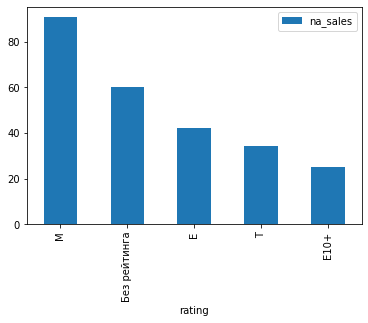

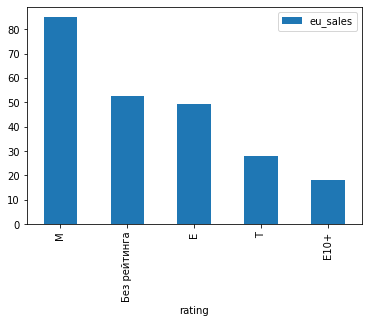

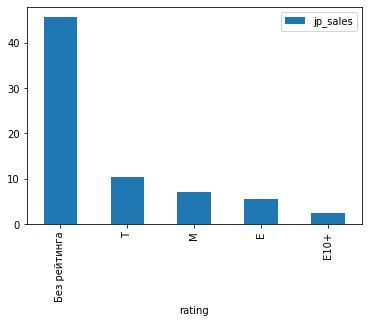

In [42]:
profiler('rating', 'na_sales')
profiler('rating', 'eu_sales')
profiler('rating', 'jp_sales')

#  Проверка гипотез

## Проверим гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковы.  

**Формулируем гипотезы**  

Н0 (нулевая гипотеза) - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; 

Н1 (альтернативная гипотеза) - Средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.

In [43]:
actual_platform = games.query('platform in @list_platform or year_of_release >= 2014')
rating_xone = actual_platform.query('platform == "XOne"')['user_score'].dropna() 
rating_pc = actual_platform.query('platform == "PC"')['user_score'].dropna() 

alpha = 0.05
results = st.ttest_ind(rating_xone, rating_pc)
display('p-значение:', results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

0.21023248115132503

'Не получилось отвергнуть нулевую гипотезу'

In [44]:
actual_platform.query('platform =="XOne" or platform =="PC"').pivot_table(
    index='platform', values='user_score', aggfunc=['mean','median']).round(2)

,mean,median
,user_score,user_score
platform,,
PC,6.30,6.8
XOne,6.52,6.8


Не получилось опровергнуть Нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC на 11%.

## Средние пользовательские рейтинги жанров Action и Sports разные
В данной проверке гипотезы, мы рассматриваем две генеральные совокупности - игры жанров Action и Sports

**Формулируем гипотезы**

Н0 (нулевая гипотеза)- Cостоит в том, что что средние пользовательские рейтинги жанров Action и Sports одинаковы.   
Н1 (альтернативная гипотеза) -  Cостоит в том, средние пользовательские рейтинги жанров Action и Sports отличаются.

In [45]:
rating_action = actual_platform.query('genre == "Action"')['user_score'].dropna() 
rating_sports = actual_platform.query('genre == "Sports"')['user_score'].dropna() 

alpha = 0.05 
results = st.ttest_ind(rating_action, rating_sports) 

display('p-значение:', results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

2.473160735016056e-18

'Отвергаем нулевую гипотезу'

In [46]:
actual_platform.query('genre == "Action" or genre == "Sports"').pivot_table(
    index='genre', values='user_score', aggfunc=['mean','median']).round(2)

,mean,median
,user_score,user_score
genre,,
Action,6.85,7.1
Sports,6.08,6.4


Получив p-value, мы отвергли Нулевую гипотезу. Средние пользовательские рейтинги различаются, и практически нулевая вероятность говорит о том, что случайно получить такое отличие в значениях практически не получится, рейтинги Action намного выше.

#  Общий вывод: 

 
1) Игровая индустрия начала активно развиваться с 1994 года, до этого объем был невысоким. Жизненный цикл платформы около 10 лет, первую половину которых идет плавный рост продаж, а вторую - спад. Необходимо рассматривать не самый дальний врменной интервал для более точной оценки рынков. 

2)  Популярные консоли в мире принадлежат компаниям Sony и Microsoft. Среднестатические игроки Северной Америки и Европы похожи. Рынок видео игр в Японии отличается от остального мира. Они предпочитают портативные консоли и игры жанра RPG.

3)  PC, PS4, PSV, XOne, WiiU, и X360 - растущие плафтормы и наиболее прибыльные в прогнозе, но если рассматривать отдельно японский рынок, целесообразно сделать ставку на платформу 3DS.   

4)  Для прогнозирования успешной видеоигры необходимо изучить оценки критиков, так как есть прямая зависимость между этим параметром и объемом продаж.

5)  Самые продаваемые игровые жанры - Action, Shooter, Role-Playing у японского рынка. 

6)  Возрастные рейтинги самых популярных игр - M(17+), Без рейтинга, E(6+).

7) Средние пользовательские рейтинги платформ Xbox One и PC отличаются незначительно. Отвергаем нулевую гипотезу,  средние пользователские рейтинги для жанров Action и Sports отличаются.